We have the chance to move into *two* sites up and *two* sites down, each site has a rate $r_i = \nu \exp(-E_i/kBT)$, but the two sites are equivalent, so simply double $\nu$ so $\nu \rightarrow 2\nu$ and then just consider moving up or down into *one* site.

Total rate is then $R = r_{up} + r_{down}$, this is *not* normalised to be anything.

We thus have the probability of any event occuring, $P_{up} = r_{up} / R$, this is inherintly normalised such that $P_{up} + P_{down} = 1$

Can use $R$ to select from a Poisson-like probability distribution (why?) to determine when the next event will occur $p(t) = R \exp(-Rt)$, i.e., this shows the probability of it being a time $t$ that is chosen to advance time forward by.

$t = -\ln(u) \frac{1}{R}$ where u is a uniformly distributed number between 0 and 1, advance time forward that amount.

Pick another random number $u$ and use that to determine which event occured using the usual method.

### TODO:

The quality of kMC is ultimately determined by the quality of the input data, redo your MD runs because they're probably shite!

Make a short script to run the kMC at various temps for a certain amount of time, then plot them all together, can show different heating reigmes.

Maybe write up the functions in C and then do simple pthread for speed up.

NOTE: Timeout has to be >= 1e9 when at T >= 1400K as the steps are so tiny that it will simply run out if timeout is small (1e6)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, uniform
#### CONSTANTS ####
from ase.units import kB
nu = 2 * 40e12 # can move in to two different sites when moving up or down, rate is doubled!
T = 1400
surface_distance = 18
offset = 0
bulk_energy = 2.55
up = 'up'
down = 'down'

In [5]:
data = np.loadtxt('layer.csv', delimiter=',')
# need to make functions that get, R, r_i, P_i, and t_i
# r comes from data and has a default bulk.
# can speed up by adding some ifs to auto calc it being 0.5:0.5 in bulk

def get_r(direction, distance):
    """return the rate for migration either up or down, depending on the distance from surface"""
    dir_dict = {"up": 1, "down": 2}
    index = distance
    if distance >= 0:
        E = data[index][dir_dict[direction]]
        return nu * np.exp(-E/(kB*T))
    else: # assume in bulk, so both directions are equal
        return nu * np.exp(-bulk_energy/(kB*T))

def get_R(distance):
    """return the total rate R for a certain distance"""
    return get_r("up", distance) + get_r("down", distance)

def get_P(direction, distance):
    """return the probability of migrating up or down depending on distance"""
    return get_r(direction, distance) / get_R(distance)

def get_t(distance, u=random()):
    """RANDOM PROCESS: get time for migration to occur over, can pass in u if want to keep it consistent"""
    return -np.log(u) / get_R(distance)


In [15]:

def kmc_loop(time_length=0.02 * 3600, starting_distance=0, timeout=1e9):
    distance = starting_distance
    dist_arr = [distance]
    time = 0
    time_arr = [time]
    reached_surface = False
    for _ in range(int(timeout)):
        if distance >= surface_distance:
            #print("reached surface")
            reached_surface = True
            break
        
        u = random()
        if u < get_P(up, distance):
            distance += 1
        elif u >= get_P(up, distance):
            distance -= 1
        else:
            print("CATCH ME")
        time += get_t(distance)
        if time > time_length:
            break
        time_arr.append(time)
        dist_arr.append(distance)
    return np.array(time_arr), np.array(dist_arr), reached_surface

plt.style.use('seaborn')
colour = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.ylabel("Layers From Surface")
plt.xlabel('Time / hours')

vacancies_destroyed = 0

# find a *nice* way to plot the surfaced ones last
surfaced_times = []
surfaced_distances = []
num_runs = 50

for i in range(num_runs):
    print(i)
    time, dist, reached_surface = kmc_loop(10 * 3600, int(uniform(0, -100)))
    if reached_surface:
        surfaced_times.append(time)
        surfaced_distances.append(dist)
        vacancies_destroyed += 1
    else:
        plt.plot(time/3600, dist-surface_distance, color='lightslategray',alpha=0.3)
        
for time, dist in zip(surfaced_times, surfaced_distances): 
        plt.plot(time/3600, dist-surface_distance, color=colour[0], alpha=0.75)
 
print(vacancies_destroyed, "out of", num_runs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


(array([23.,  9.,  3.,  2.,  3.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.0130374 , 0.38420082, 0.75536424, 1.12652767, 1.49769109,
        1.86885451, 2.24001794, 2.61118136, 2.98234478, 3.35350821,
        3.72467163, 4.09583505, 4.46699848, 4.8381619 , 5.20932532,
        5.58048875, 5.95165217, 6.32281559, 6.69397902, 7.06514244,
        7.43630586, 7.80746929, 8.17863271, 8.54979613, 8.92095956,
        9.29212298]),
 <BarContainer object of 25 artists>)

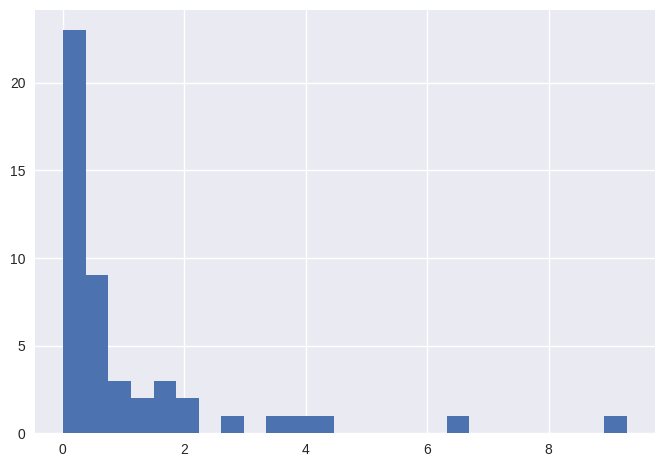

In [7]:
final_times = []
for times in surfaced_times:
    final_times.append(times[-1]/3600)
plt.hist(final_times, bins=25)